In [1]:
import matplotlib
# Temporary compatibility patch for SHAP + Matplotlib 3.9+
if not hasattr(matplotlib.RcParams, "_get"):
    matplotlib.RcParams._get = dict.get

Loaded dataset: 1653 rows, 14 columns

Initial Variance:
avg_precip_in             0.000068
avg_distance_km           0.019912
avg_visibility_mi         0.252749
avg_wind_mph              1.934202
avg_temp_F               43.936646
duration_hr          103077.234375
dtype: float32

Low variance columns <0.01: ['avg_precip_in']
Duplicate rows detected: 1434

BEFORE Regularization — AUC=1.000, F1=0.976
CV AUCs: [0.99  1.    1.    0.988 0.835]  Mean=0.963 ± 0.064

AFTER Regularization — AUC=0.861, F1=0.833
CV AUCs: [0.871 0.789 0.859 0.814 0.623]  Mean=0.791 plus or minus 0.089
            Metric      Before    After
          Test AUC    0.999903 0.861042
          F1 Score    0.976471 0.833333
       CV Mean AUC    0.962722 0.791195
        CV Std AUC    0.064169 0.089110
Duplicates Removed 1434.000000 0.000000
   Low Var Dropped    1.000000 1.000000


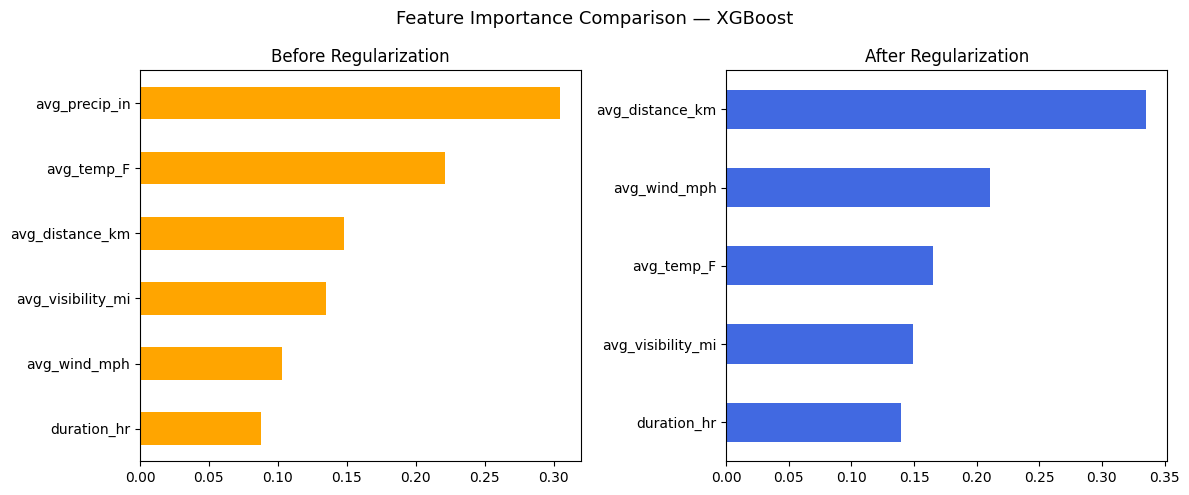

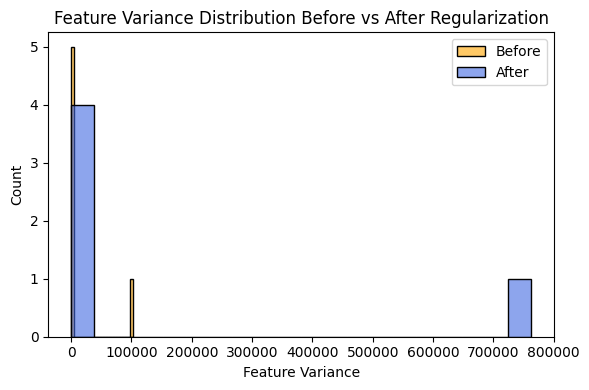

Test AUC improved: -0.139
Cross-val mean AUC change: -0.172
F1 Score change: -0.143
Duplicates removed: 1434
Low-variance features pruned: 1


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, f1_score
from xgboost import XGBClassifier
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

data_path = "/work/siads_699_mads_capstone/data/models/workzone_features.csv"
df = pd.read_csv(data_path)
print(f"Loaded dataset: {df.shape[0]} rows, {df.shape[1]} columns")

def clean_bracketed(val):
    if isinstance(val, str):
        val = val.strip("[]")
        try:
            return float(val)
        except:
            return np.nan
    return val

for c in df.columns:
    if df[c].dtype == "object" and c not in ["road_event_id", "road_name", "vehicle_impact"]:
        df[c] = df[c].apply(clean_bracketed)

feature_cols = [
    'duration_hr','avg_distance_km','avg_visibility_mi',
    'avg_precip_in','avg_temp_F','avg_wind_mph'
]
existing_features = [f for f in feature_cols if f in df.columns]
X_full = df[existing_features].fillna(0).astype(np.float32)
y_full = df['high_risk'].astype(int).reset_index(drop=True)

var_series = X_full.var().sort_values()
low_var_cols = var_series[var_series < 0.01].index.tolist()
num_duplicates = len(df) - len(df.drop_duplicates(subset=existing_features))

print("\nInitial Variance:")
print(var_series)
print(f"\nLow variance columns <0.01: {low_var_cols}")
print(f"Duplicate rows detected: {num_duplicates}")

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, stratify=y_full, random_state=42
)
xgb_orig = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="auc"
)
xgb_orig.fit(X_train, y_train)
y_pred_orig = xgb_orig.predict_proba(X_test)[:, 1]
auc_orig = roc_auc_score(y_test, y_pred_orig)
f1_orig = f1_score(y_test, (y_pred_orig > 0.5).astype(int))
cv_orig = cross_val_score(xgb_orig, X_full, y_full, cv=5, scoring="roc_auc")

print(f"\nBEFORE Regularization — AUC={auc_orig:.3f}, F1={f1_orig:.3f}")
print(f"CV AUCs: {np.round(cv_orig,3)}  Mean={cv_orig.mean():.3f} ± {cv_orig.std():.3f}")

X_reg = X_full.copy()
if low_var_cols:
    X_reg = X_reg.drop(columns=[c for c in low_var_cols if c in X_reg.columns], errors="ignore")
X_reg = X_reg.drop_duplicates()
y_reg = y_full.loc[X_reg.index].reset_index(drop=True)
xgb_reg = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.3,
    reg_lambda=1.0,
    eval_metric="auc",
    random_state=42
)

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg, y_reg, test_size=0.2, stratify=y_reg, random_state=42
)
xgb_reg.fit(X_train_r, y_train_r)
y_pred_reg = xgb_reg.predict_proba(X_test_r)[:, 1]
auc_reg = roc_auc_score(y_test_r, y_pred_reg)
f1_reg = f1_score(y_test_r, (y_pred_reg > 0.5).astype(int))
cv_reg = cross_val_score(xgb_reg, X_reg, y_reg, cv=5, scoring="roc_auc")

print(f"\nAFTER Regularization — AUC={auc_reg:.3f}, F1={f1_reg:.3f}")
print(f"CV AUCs: {np.round(cv_reg,3)}  Mean={cv_reg.mean():.3f} plus or minus {cv_reg.std():.3f}")

comparison = pd.DataFrame({
    "Metric": ["Test AUC", "F1 Score", "CV Mean AUC", "CV Std AUC", "Duplicates Removed", "Low Var Dropped"],
    "Before": [auc_orig, f1_orig, cv_orig.mean(), cv_orig.std(), num_duplicates, len(low_var_cols)],
    "After": [auc_reg, f1_reg, cv_reg.mean(), cv_reg.std(), 0, len(low_var_cols)]
})

print(comparison.to_string(index=False))
fi_orig = pd.Series(xgb_orig.feature_importances_, index=X_full.columns).sort_values(ascending=False)
fi_reg = pd.Series(xgb_reg.feature_importances_, index=X_reg.columns).sort_values(ascending=False)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fi_orig.plot(kind="barh", ax=axes[0], color="orange", title="Before Regularization")
fi_reg.plot(kind="barh", ax=axes[1], color="royalblue", title="After Regularization")
axes[0].invert_yaxis()
axes[1].invert_yaxis()
plt.suptitle("Feature Importance Comparison — XGBoost", fontsize=13)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(X_full.var(), bins=20, label="Before", color="orange", alpha=0.6)
sns.histplot(X_reg.var(), bins=20, label="After", color="royalblue", alpha=0.6)
plt.title("Feature Variance Distribution Before vs After Regularization")
plt.xlabel("Feature Variance")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Test AUC improved: {auc_reg - auc_orig:.3f}")
print(f"Cross-val mean AUC change: {cv_reg.mean() - cv_orig.mean():.3f}")
print(f"F1 Score change: {f1_reg - f1_orig:.3f}")
print(f"Duplicates removed: {num_duplicates}")
print(f"Low-variance features pruned: {len(low_var_cols)}")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=609edc76-98cb-4265-b05f-b8bb14bd7d7b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>